In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2023-11-19 14:07:42.356148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 14:07:42.385289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 14:07:42.385321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 14:07:42.386407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 14:07:42.391930: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
train_dir = "../data/data_fer_bin/train"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 8
LR = 0.01
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['negative', 'neutral', 'positive']
CLASS_LABELS_EMOJIS = ["😱" , "😐 ", "😊"]

In [4]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

# preprocess_fun = tf.keras.applications.densenet.preprocess_input
preprocess_fun = to_grayscale_then_rgb

train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.05, rescale = 1./255, validation_split = 0.2, preprocessing_function=preprocess_fun)

test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir, target_size = (IMG_HEIGHT ,IMG_WIDTH), batch_size = BATCH_SIZE, shuffle  = True ,  color_mode = "rgb", class_mode = "categorical", subset = "training")

validation_generator = test_datagen.flow_from_directory(directory = train_dir, target_size = (IMG_HEIGHT ,IMG_WIDTH), batch_size = BATCH_SIZE, shuffle  = True ,  color_mode = "rgb", class_mode = "categorical", subset = "validation")



Found 30166 images belonging to 3 classes.
Found 7540 images belonging to 3 classes.


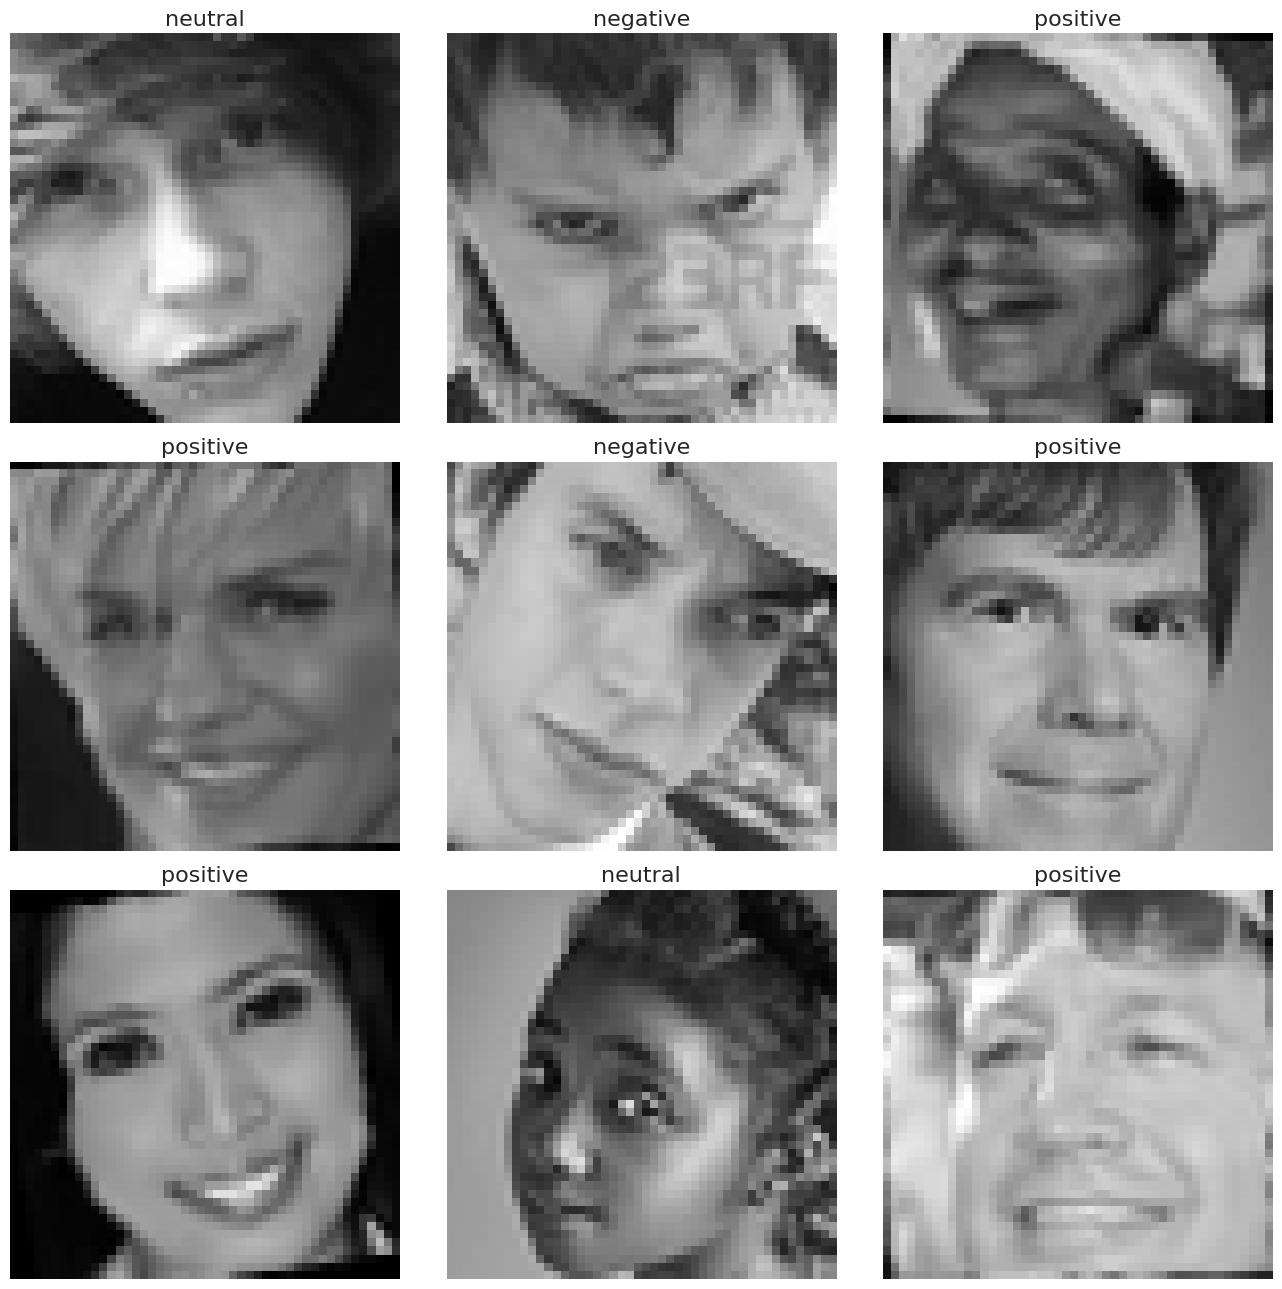

In [5]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir, target_size = (IMG_HEIGHT ,IMG_WIDTH), batch_size = BATCH_SIZE, shuffle  = True ,  color_mode = "rgb", class_mode = "categorical")

clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [8]:
fig = px.bar(x = CLASS_LABELS_EMOJIS, y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,  color = np.unique(train_generator.classes) , color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [9]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [10]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

In [11]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose= 1 , restore_best_weights=True)

with tf.device('/gpu:0'):
    history = model.fit(x = train_generator, epochs = EPOCHS, validation_data = validation_generator,  callbacks= [earlyStoppingCallback])
    history = pd.DataFrame(history.history)

Epoch 1/30


2023-11-19 14:08:59.448953: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-11-19 14:08:59.527108: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 14:08:59.666302: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 14:09:03.669885: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83eddd7df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 14:09:03.669925: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1700392143.720781  641116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


472/472 [==============================] - 97s 135ms/step - loss: 7.7665 - accuracy: 0.6084 - val_loss: 3.1377 - val_accuracy: 0.6541
Epoch 2/30
472/472 [==============================] - 53s 113ms/step - loss: 1.6517 - accuracy: 0.7603 - val_loss: 1.2517 - val_accuracy: 0.6700
Epoch 3/30
472/472 [==============================] - 53s 111ms/step - loss: 0.6982 - accuracy: 0.7935 - val_loss: 0.7090 - val_accuracy: 0.7548
Epoch 4/30
472/472 [==============================] - 53s 112ms/step - loss: 0.5270 - accuracy: 0.8070 - val_loss: 0.6424 - val_accuracy: 0.7476
Epoch 5/30
472/472 [==============================] - 53s 111ms/step - loss: 0.4710 - accuracy: 0.8244 - val_loss: 0.5408 - val_accuracy: 0.7874
Epoch 6/30
472/472 [==============================] - 53s 111ms/step - loss: 0.4454 - accuracy: 0.8323 - val_loss: 0.5766 - val_accuracy: 0.7844
Epoch 7/30
472/472 [==============================] - 53s 112ms/step - loss: 0.4135 - accuracy: 0.8483 - val_loss: 0.7355 - val_accuracy: 0.7

In [12]:
model.layers[1].trainable = True
model.compile(optimizer=tf.keras.optimizers.SGD(0.002), loss='categorical_crossentropy', metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
472/472 [==============================] - 74s 113ms/step - loss: 0.3839 - accuracy: 0.8620 - val_loss: 0.4918 - val_accuracy: 0.8206
Epoch 2/20
472/472 [==============================] - 54s 113ms/step - loss: 0.3534 - accuracy: 0.8768 - val_loss: 0.4989 - val_accuracy: 0.8204
Epoch 3/20
472/472 [==============================] - 55s 116ms/step - loss: 0.3427 - accuracy: 0.8781 - val_loss: 0.4964 - val_accuracy: 0.8247
Epoch 4/20
472/472 [==============================] - 53s 112ms/step - loss: 0.3304 - accuracy: 0.8821 - val_loss: 0.5011 - val_accuracy: 0.8247
Epoch 5/20
472/472 [==============================] - 53s 112ms/step - loss: 0.3211 - accuracy: 0.8876 - val_loss: 0.5018 - val_accuracy: 0.8233
Epoch 6/20
472/472 [==============================] - 54s 115ms/step - loss: 0.3142 - accuracy: 0.8906 - val_loss: 0.5129 - val_accuracy: 0.8233
Epoch 7/20
472/472 [==============================] - 57s 120ms/step - loss: 0.3102 - accuracy: 0.8923 - val_loss: 0.5083 - val_ac

In [13]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [14]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [15]:
model.save('../../models/model_pictures_fer_bin.h5')


In [16]:
test_dir = "../data/data_fer_bin/test"

test_generator = test_datagen.flow_from_directory(directory = test_dir, target_size = (IMG_HEIGHT ,IMG_WIDTH), batch_size = BATCH_SIZE, shuffle  = False ,  color_mode = "rgb", class_mode = "categorical")
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

Found 6347 images belonging to 3 classes.
100/100 [==============================] - 8s 72ms/step


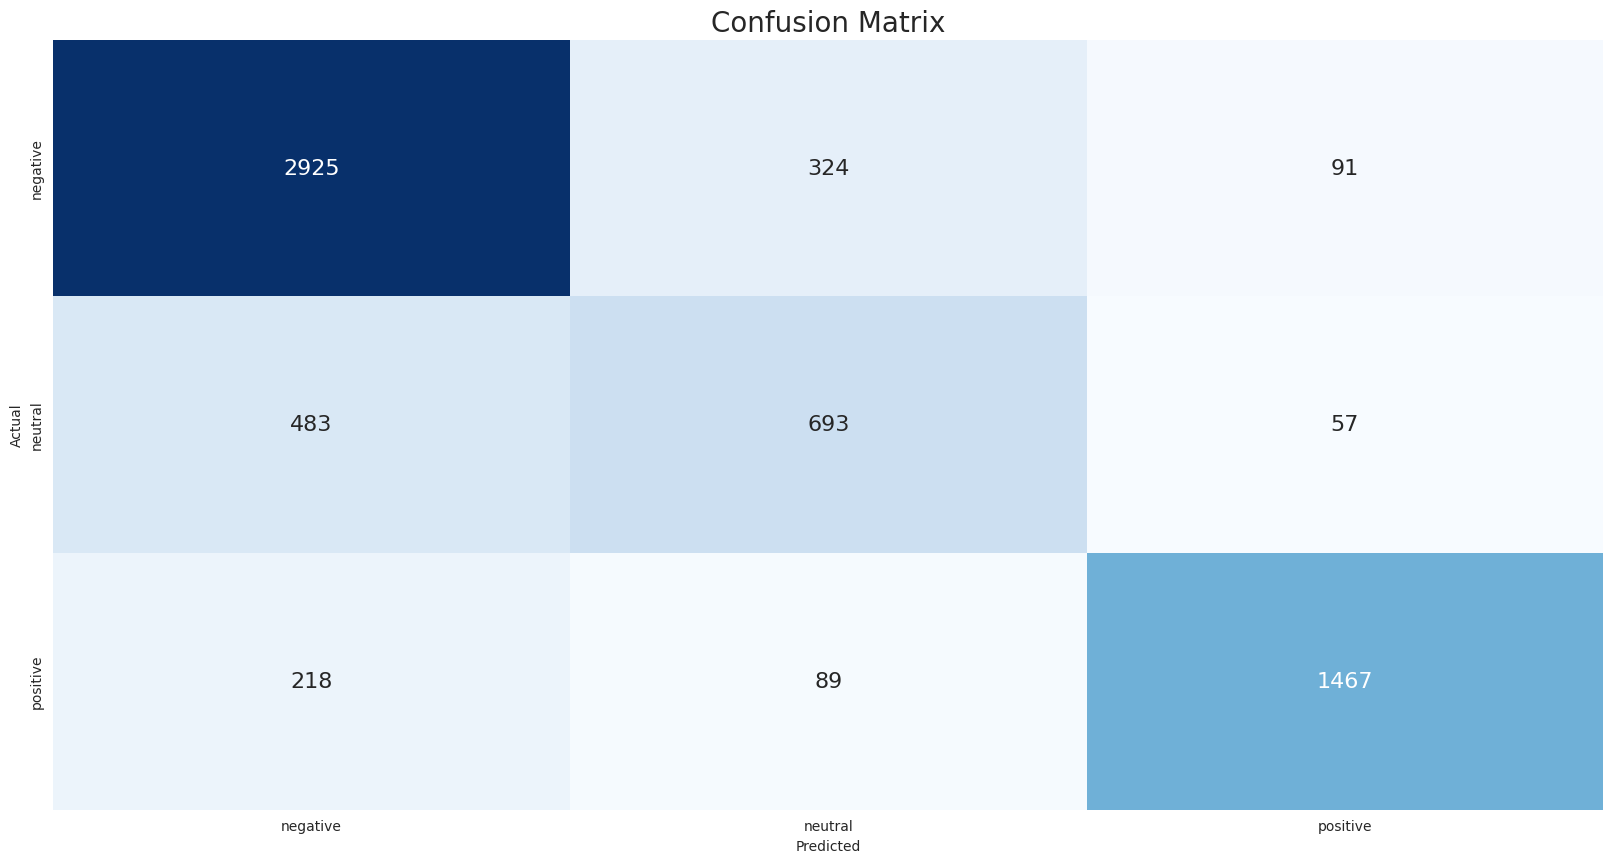

In [17]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(20, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [18]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [19]:
f1_score(y_preds, y_test, average="weighted")

0.8033143726396967

In [20]:
recall_score(y_preds, y_test, average="weighted")

0.8011659051520403

In [21]:
precision_score(y_preds, y_test, average="weighted")

0.8086655574842467